In [1]:
import numpy as np
import pandas as pd
import json
from scipy.signal import find_peaks
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

import src.utilities as utils
from src.slide_utilities import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
adata_all = sc.read_h5ad("data/adata_nichepca_slide_clustered_tmp.h5ad")

In [3]:
sample_set = adata_all.obs['Patient_Sample_ID'].unique()
sample_set

['X40_SLE', 'X39_SLE', 'X38_GBM', 'X37_ANCA', 'X36_ANCA', ..., 'X21_GBM', 'X20_ANCA', 'X19_ANCA', 'X18_ANCA', 'X17_ANCA']
Length: 63
Categories (63, object): ['X1_Cntrl', 'X2_Cntrl', 'X3_ANCA', 'X4_ANCA', ..., 'X60_ANCA', 'X61_SLE', 'X62_SLE', 'X63_ANCA']

In [4]:
adata = adata_all[adata_all.obs['Patient_Sample_ID'] == "X17_ANCA"]

In [5]:
cols = list(adata.obs.columns)
cols_with_leiden = [c for c in cols if c.find('leiden') > 0]
cols_with_leiden

['all_slide_leiden_0.1',
 'all_slide_leiden_0.3',
 'all_slide_leiden_0.5',
 'per_slide_leiden_0.1_1',
 'per_slide_leiden_0.1_2',
 'per_slide_leiden_0.2_1',
 'per_slide_leiden_0.2_2',
 'per_slide_leiden_0.3_1',
 'per_slide_leiden_0.3_2']

In [6]:
# add cluster markers
resolution_best = cols_with_leiden[5]

adata = add_markers(adata, 
                    markers = KidneyCellMarkers, 
                    groupby = resolution_best,
                    colormap = colormap,
                    marker_subset = marker_subset, 
                    keyadded = 'final_clusters',
                    verbos=True,
                    return_adata = True
                   )

Cluster number to marker dict:
{'3': {'set': 'Glom.', 'max': 0.27723077, 'diff': 0.2749623858064471}, '1': {'set': 'Prox. Tubule', 'max': 0.23730083, 'diff': 0.22716317567263722}, '2': {'set': 'DistaL Con. Tubule', 'max': 0.26260614, 'diff': 0.25482986392736034}}


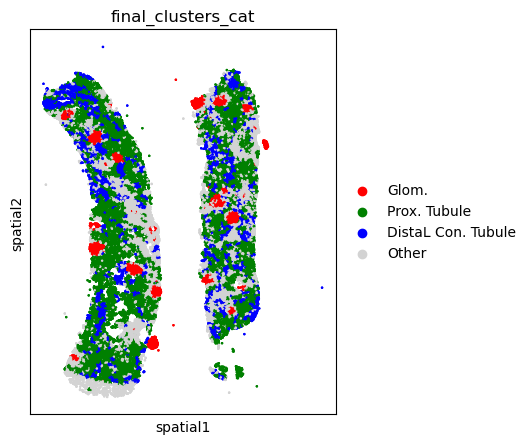

In [7]:
# spatial plot
fig, ax = plt.subplots(figsize=(5, 5))
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=['final_clusters_cat'],
    wspace=0.1,
    ax = ax
)

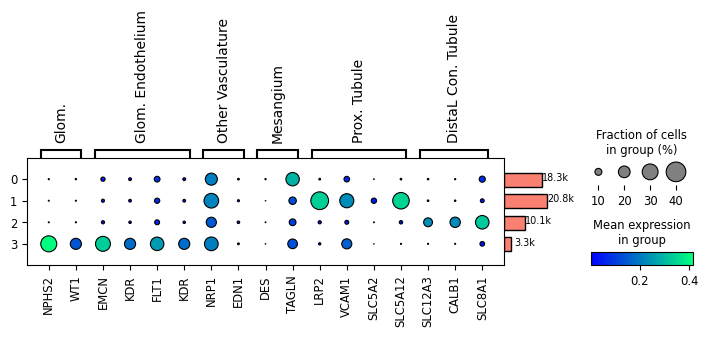

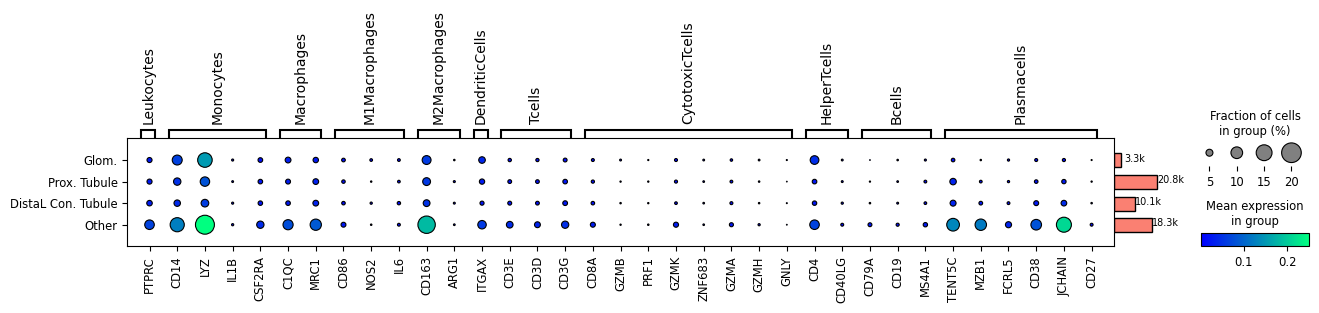

In [8]:
Markers = remove_extra_genes(KidneyCellMarkers, adata)
dp = sc.pl.dotplot(adata, Markers, groupby=resolution_best, use_raw=False, return_fig=True)
dp.style(dot_edge_color='black', dot_edge_lw=.8)
dp.add_totals()
# dp.savefig("marker.pdf")
dp.show()

# Immunological enrichment
Markers = remove_extra_genes(ImmuneMarkers, adata)
dp = sc.pl.dotplot(adata, Markers, groupby='final_clusters_cat', use_raw=False, return_fig=True)
dp.style(dot_edge_color='black', dot_edge_lw=.8)
dp.add_totals()
dp.show()

## Do all in a loop

In [9]:
adata_all = sc.read_h5ad("data/adata_nichepca_slide_clustered_tmp.h5ad")
sample_set = adata_all.obs['Patient_Sample_ID'].unique()
resolution_best = 'per_slide_leiden_0.2_1'

In [10]:
adata_all.obs['domains'] = 'na'

for sample in tqdm(sample_set):

    adata = adata_all[adata_all.obs['Patient_Sample_ID'] == sample]
    
    # add cluster markers
    adata = add_markers(adata, 
                        markers = KidneyCellMarkers, 
                        groupby = resolution_best,
                        colormap = colormap,
                        marker_subset = marker_subset, 
                        keyadded = 'final_clusters',
                        verbos=False,
                        return_adata = True
                       )
    
    adata_all.obs.loc[adata_all.obs['Patient_Sample_ID'] == sample ,'domains'] = adata.obs['final_clusters_cat']
    

100%|██████████| 63/63 [2:06:08<00:00, 120.13s/it]  


In [14]:
adata_all.obs

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,all_slide_leiden_0.3,all_slide_leiden_0.5,per_slide_leiden_0.1_1,per_slide_leiden_0.1_2,per_slide_leiden_0.2_1,per_slide_leiden_0.2_2,per_slide_leiden_0.3_1,per_slide_leiden_0.3_2,per_slide_is_glom_tmp,domains
cell_CRfb095a77d-1,2285.790178,1164.057381,32.829188,1,79,2.0240,2.141,39.03,0.9975,0.9916,...,0,0,1,1,0,3,0,3,0,Prox. Tubule
cell_CRfb095a77d-2,2298.342622,1219.741069,31.465535,4,32,1.0850,4.614,29.50,0.9771,0.9288,...,0,0,1,1,0,3,0,3,0,Prox. Tubule
cell_CRfb095a77d-3,2271.434052,1245.859500,32.062796,2,67,3.0590,2.990,21.90,0.9971,0.9884,...,2,2,0,3,3,4,3,4,0,DistaL Con. Tubule
cell_CRfb095a77d-5,2257.346907,1259.955827,31.273945,2,56,2.1420,9.229,26.14,0.9964,0.9707,...,2,2,0,3,3,4,3,4,0,DistaL Con. Tubule
cell_CRfb095a77d-6,2277.712022,1237.595244,35.395148,2,9,1.6980,3.283,5.30,0.9826,0.9400,...,3,3,0,3,3,4,3,4,0,DistaL Con. Tubule
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_CRc71d71060-597925,2747.360264,4957.516627,24.097605,2,73,1.5480,3.617,47.15,0.9971,0.6334,...,3,3,0,0,0,0,0,3,0,Other
cell_CRc71d71060-598041,4592.548620,1655.438877,24.254944,2,35,0.9893,1.844,35.38,0.9951,0.6206,...,3,3,0,0,0,0,0,0,0,Other
cell_CRc71d71060-598270,8540.113826,9224.561804,19.515240,3,46,1.3870,2.667,33.16,0.9969,0.7152,...,3,1,0,0,0,0,0,0,0,Other
cell_CRc71d71060-598508,4264.902000,2582.697217,25.121288,3,24,1.1420,5.004,21.02,0.9914,0.7517,...,3,3,0,0,0,5,0,3,0,Other


In [13]:
adata_all.write("data/adata_nichepca_all_with_domain.h5ad")